# Lecture 5: Incorporating Qualitative Data (Completed version)

**Overview**

- Identify **types of qualitative data**.

- Choose an **appropriate encoding** for qualitative variables.

- Interpret dummy coefficients as **level differences** and numeric coefficients as **slopes**.  

- Spot and fix common **misuses**.

---


# Kickoff — Quantitative vs Qualitative

## 🔎 Quantitative vs Qualitative Data

- **Quantitative data**

  - Measured on a numeric scale where arithmetic operations (addition, subtraction, averaging) are meaningful.

  - **Examples:** 
  
    - Years of education (12, 13, 14 …)

    - Annual income ($45,000, $52,000 …)

    - Test scores (0–100)  

  ✅ Interpretation: a one-unit difference has a consistent meaning (e.g., +1 year of education).

<hr style="border: 1px dotted #bbb;">

- **Qualitative data (categorical)**

  - Data that classify individuals into groups or labels.

  - Since OLS/regression requires numeric inputs, we must **encode** qualitative variables into numbers *(typically 0/1 indicator “dummy” variables)*.

  - Numbers used to code categories are **labels only** — arithmetic on them is **not** meaningful.

  **Common qualitative types:**

  - **Binary (2 levels):** Public/Private; Treated/Control  

    > **Interpretation in regression:** the coefficient on a binary regressor is the **difference between the two groups**, holding other covariates fixed.

  - **Nominal (no order):** Industry (Tech/Finance/Education), State (CA/NY/TX), Major (Econ/Math/CS)

  - **Ordinal (has order, spacing not guaranteed equal):** Education level (HS/BA/MA/PhD)  

    > ⚖️ If the spacing between categories is truly equal and numeric (e.g., **years** of education), then it’s **quantitative**, not ordinal.

  > ℹ️ With only **two categories**, the idea of “order” doesn’t change how we model it — coding as 0/1 is just a labeling choice.


<hr style="border: 1px dotted #bbb;">

### 🚫 What does “arithmetic is not meaningful” mean?

- If we code `Industry` as Tech=1, Finance=2, Education=3:

  - $2 - 1 = 1$ (Finance – Tech) → there is no such thing as “Finance is one unit more than Tech.”  

  - Average(1,3) = 2 → does **not** mean “Finance.”

- If we code `Browser` as Chrome=1, Firefox=2, Safari=3, Edge=4:

  - $4 - 1$ has no interpretation (“Edge is three units more than Chrome” is nonsense).

  - An average like $2.6$ is **not** a browser.

- If we code `ProgramParticipation` as No=0, Yes=1:

  - $0.5$ is not “half participated.”

⚠️ Treating these codes as numbers **creates fake order or distance** that does not exist.

✅ **Solution**: use **dummy variables**.

<hr style="border: 1px dotted #bbb;">

### 📌 **Clarification: “Qualitative” in Econometrics vs. Broader Research**

- In **this lab**, “qualitative variables” = **categorical variables** (binary, nominal, ordinal).

- In **broader research**, “qualitative data” can also mean **rich, unstructured sources**:

  - **Text** (interviews, open-ended responses), **audio/video**, **images**, field notes.

    🧩 **How to use them in regression?**
     - We **cannot** directly include raw qualitative data (e.g., text, images) in regression.

     - We create **quantitative features** from the raw content (a.k.a. encoding):
    
       - sentiment scores from news articles
    
       - topic proportions from interview transcripts
    
       - color histograms from images
  
> ✅ **Takeaway:** 
> - For this lab, qualitative = **categorical**.
>
> - For richer qualitative sources, we must **engineer quantitative features first**, then use standard econometric tools.

---

## 📦 Required libraries
We’ll use these standard Python libraries in this lab:

- [`numpy`](https://numpy.org/) — arrays, random data generation, basic math operations.

- [`pandas`](https://pandas.pydata.org/) — data frames and categorical encoding (e.g., `pd.get_dummies` for dummy variables).

- [`statsmodels`](https://www.statsmodels.org/) — conduct OLS estimations and provide model summaries.

- [`matplotlib`](https://matplotlib.org/) — quick plots to visualize data and fitted lines.


In [6]:
# Install the required packages together
!pip install numpy pandas statsmodels matplotlib --quiet

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf # for R-style formulas
import matplotlib.pyplot as plt

---


## 🎯 Tiny Toy Dataset — used in all sections

We’ll model **wage** as a function of :

- two **quantitative** regressors (**education** and **experience**), and 

- one **qualitative** regressors

    - **industry** with 3 levels
        - tech
        - finance
        - education


In [7]:

rng = np.random.default_rng(10) # Set random seed for reproducibility

n = 300
df = pd.DataFrame({
    "educ":  rng.integers(0, 19, n),                 # quantitative: randomly drawn integers from [0, 19)
    "exper": rng.integers(0, 12, n),                  # quantitative: randomly drawn integers from [0, 12)
    "industry": rng.choice(["Tech","Finance","Edu"], size=n, p=[0.4,0.35,0.25]),  # nominal (3): unordered categorical from 3 categories with probabilities 0.4, 0.35, 0.25
})

# Generate wage with additive effects + noise 
base = 5.0 # intercept
b_educ, b_exper = 1.2, 0.8 # coefficients for educ, exper 
industry_shift = {"Edu": 0.0, "Finance": 3.0, "Tech": 5.0} # additive shifts for industry categories
noise = rng.normal(0, 2.0, size=n) # Gaussian noise N(0, 2.0)

df["wage"] = base + b_educ*df["educ"] + b_exper*df["exper"] + df["industry"].map(industry_shift) + noise # create wage according to the DGP

df.head(8)


,educ,exper,industry,wage
0,14,3,Finance,24.522303
1,18,3,Finance,33.438833
2,5,10,Tech,21.048015
3,3,0,Finance,9.998917
4,15,10,Edu,33.830628
5,15,2,Finance,26.180729
6,9,10,Edu,25.942335
7,2,9,Finance,16.874144


### **Recall: DGP (data-generating process)**

- In this **synthetic** example, we know exactly how the data were created (we made them).  

- We generated `wage` as a **linear function** of years of **education** (`educ`), years of **experience** (`exper`), and an **industry effect**, plus random noise:

$$
\text{wage}_i
= 5
+ 1.2\,\text{educ}_i
+ 0.8\,\text{exper}_i
+ \text{industry\_shift}_i
+ \varepsilon_i,\qquad \varepsilon_i \sim \mathcal{N}(0,\,2^2).
$$

> **Interpretation (in this toy DGP):**
> - **Intercept 5**: baseline level for the **baseline industry** when `educ = exper = 0`.
>
> - **1.2 on `educ`**: holding other variables fixed, **+1 year of education → +1.2** (units of wage).
>
> - **0.8 on `exper`**: holding other variables fixed, **+1 year of experience → +0.8**.
>
> - **`industry_shift_i`**: **additive difference by industry** relative to the baseline (we use **Edu** as baseline).  
>
>   For our encoding: **Edu = 0**, **Finance = +3**, **Tech = +5** (i.e., parallel intercept shifts).

<hr style="border: 1px dotted #bbb;">

### Making the industry term explicit (dummy encoding)

- We encode `industry` with **dummy (0/1) indicators** and **omit one baseline**:

- Baseline (omitted) category = **Edu**  
- $\mathbf{1}\{\text{Finance}_i\}=1$ if obs $i$ is Finance, else 0  
- $\mathbf{1}\{\text{Tech}_i\}=1$ if obs $i$ is Tech, else 0

Then
$$
\text{wage}_i
= 5
+ 1.2\,\text{educ}_i
+ 0.8\,\text{exper}_i
+ 3\cdot \mathbf{1}\{\text{Finance}_i\}
+ 5\cdot \mathbf{1}\{\text{Tech}_i\}
+ \varepsilon_i.
$$

Equivalently,
$$
\text{industry\_shift}_i =
\begin{cases}
0 & \text{Edu (baseline)}\\
3 & \text{Finance}\\
5 & \text{Tech}
\end{cases}
$$
(implemented via the two dummy columns above).

**Reality check:** In real data we **don’t know** the DGP; we **estimate** a model and assess assumptions/robustness.

---

## 1) Estimate the model using OLS

We fit:
$$
\text{wage}_i
= \beta_0
+ \beta_{\text{educ}}\;\text{educ}_i
+ \beta_{\text{exper}}\;\text{exper}_i
+ \beta_{\text{Fin}}\;\mathbf{1}\{\text{industry}_i=\text{Finance}\}
+ \beta_{\text{Tech}}\;\mathbf{1}\{\text{industry}_i=\text{Tech}\}
+ u_i.
$$

- **Baseline industry:** Edu (omitted).
- $\mathbf{1}\{\cdot\}$ is an indicator: 1 if the condition is true, 0 otherwise.

In [8]:
# ✅ Formula approach (recommended)
m = smf.ols("wage ~ educ + exper + C(industry, Treatment(reference='Edu'))", data=df).fit()
m.params

# If you want more details 
# print(m.summary())

Intercept                                             4.786375
C(industry, Treatment(reference='Edu'))[T.Finance]    2.917626
C(industry, Treatment(reference='Edu'))[T.Tech]       5.157772
educ                                                  1.198405
exper                                                 0.805784
dtype: float64

In [9]:
# ✅ Manual dummies approach (no formula)

# 1) Numeric regressors
X_num = df[['educ', 'exper']]

# 2) Industry dummies — make Edu the baseline by dropping its column explicitly
D = pd.get_dummies(df['industry'], prefix='industry', drop_first=True, dtype=float) # drop_first=True drops the first column (Edu), dtype=float ensures numeric dtype (1/0 instead of True/False).
# Now D has two columns: 'industry_Finance', 'industry_Tech'

# 3) Combine and add intercept
X = pd.concat([X_num, D], axis=1)
X = sm.add_constant(X)

# 4) Fit OLS
y = df['wage']
m_manual = sm.OLS(y, X).fit()
m_manual.params

const               4.786375
educ                1.198405
exper               0.805784
industry_Finance    2.917626
industry_Tech       5.157772
dtype: float64

---

## 2) Visualize as **parallel shifts**

Now, we would like to:

- Fix `exper` at its median, and

- Plot **predicted wage vs education** for each industry.  

With a common slope on `educ` and different intercepts by industry, the fitted lines are **parallel**.

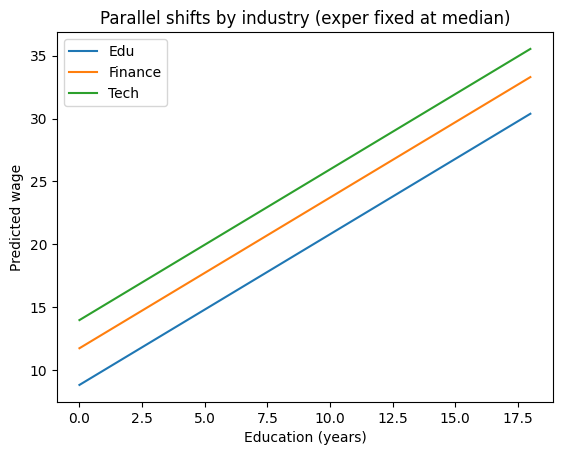

In [10]:
educ_grid = np.linspace(df['educ'].min(), df['educ'].max(), 50) # make a grid of educ values educ_grid = [10, 10.18, ..., 18] in total 50 points
exper_fix = float(df['exper'].median()) # fix exper at its median value

plt.figure()

for ind in ['Edu', 'Finance', 'Tech']:
    grid = pd.DataFrame({
        'educ': educ_grid, 
        'exper': exper_fix,
        'industry': np.repeat(ind, len(educ_grid)) # repeat the industry category to match the length of educ_grid
    })
    yhat = m.predict(grid)  # predict wage on the created grid of values: educ varies across the grid, exper is fixed, industry varies across the 3 lines
    plt.plot(educ_grid, yhat, label=ind)

plt.xlabel("Education (years)")
plt.ylabel("Predicted wage")
plt.title("Parallel shifts by industry (exper fixed at median)")
plt.legend()
plt.show()


---

## 3) ⚠️ Misuse: include **all** categories + intercept (dummy-variable trap)

⚠️ If you include **all** industry dummies **and** an intercept, this makes the model **non-identifiable** (answer will not be unique).

⚠️ This is related to the concept of **perfect multicollinearity** in regression analysis, which we will cover in more detail in next lecture.


---


## References & Acknowledgments

- This teaching material was prepared with the assistance of **OpenAI's ChatGPT (GPT-5)**.

---

**End of lecture notebook.**